<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/InitializationStrategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: how to rescale x and y to 0, 1 in pytorch

import torch

def rescale_to_01(tensor):
  """Rescales a PyTorch tensor to the range [0, 1].

  Args:
    tensor: A PyTorch tensor.

  Returns:
    A PyTorch tensor with values rescaled to the range [0, 1].
  """
  min_vals = torch.min(tensor, dim=-1, keepdim=True)[0]  # Find minimum values along the last dimension
  max_vals = torch.max(tensor, dim=-1, keepdim=True)[0]  # Find maximum values along the last dimension

  # Avoid division by zero if min and max are the same
  rescaled_tensor = torch.where(max_vals != min_vals, (tensor - min_vals) / (max_vals - min_vals), torch.zeros_like(tensor))
  return rescaled_tensor

# Example usage
x = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y = torch.tensor([[0.5, 1.5, 2.5], [3.5, 4.5, 5.5]])


x_rescaled = rescale_to_01(x)
y_rescaled = rescale_to_01(y)

print("Original x:\n", x)
print("Rescaled x:\n", x_rescaled)

print("Original y:\n", y)
print("Rescaled y:\n", y_rescaled)

## What happens if weights and biases are initialized to 0.
Answer
- Generally speaking, this is a bad idea. Gradients cannot flow past ReLU. But if there are linear layers or leaky relu or selu activation, gradients can flow in later iterations. You will have a cold start, this is what happens in the trainable portion of control net
- Training with a constant init means symmetry does not break, all weights get same values

In [68]:
import torch
import time
import d2l.torch as d2l
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

In [186]:
class SyntheticRegression(d2l.DataModule):
  def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
    super().__init__()
    self.save_hyperparameters()
    n = num_train + num_val
    self.X = torch.randn(n, len(w))
    noise = torch.randn(n, 1) * noise
    self.y = self.X * w + b + noise


    # Rescale X and Y to 0 and 1
    self.X = (self.X) / self.X.max()
    self.y = (self.y) / self.y.max()



In [187]:
@d2l.add_to_class(d2l.Module)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
  tensors = tuple(a[indices] for a in tensors)
  dataset = torch.utils.data.TensorDataset(*tensors)
  return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train) # shuffle only if it is training set

@d2l.add_to_class(SyntheticRegression)
def get_dataloader(self, train):
  i = slice(0, self.num_train)
  if not train:
    i = slice(self.num_train, self.num_train + self.num_val)
  return self.get_tensorloader((self.X, self.y), train, i)

@d2l.add_to_class(SyntheticRegression)
def train_dataloader(self):
  return self.get_dataloader(train=True)

@d2l.add_to_class(SyntheticRegression)
def val_dataloader(self):
  return self.get_dataloader(train=False)

@d2l.add_to_class(SyntheticRegression)
def plot(self):
  d2l.plot(self.X[:, 0].detach().numpy(), self.y[:,0].detach().numpy(), fmts='.')
  d2l.plt.show()

@d2l.add_to_class(SyntheticRegression)
def visualize(self, model, title=None, labels=None):
  preds = model(self.X)
  plt.scatter(self.X[:, 0].detach().numpy(), self.y[:,0].detach().numpy(), marker='.')
  plt.scatter(self.X[:, 0].detach().numpy(), preds[:,0].detach().numpy(), marker='.')
  plt.show()

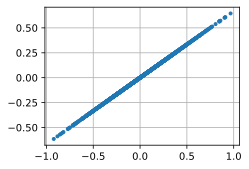

In [188]:
data = SyntheticRegression(torch.tensor([2.0, 3.0]), torch.tensor([0]), noise=0, num_train=1000, batch_size=500)
data.plot()

- Let's model this function with ReLU and try different initialization schemes

In [191]:


class LinearRegression(d2l.Module):
  def __init__(self, lr, activation=nn.ReLU, init_scheme='xavier'):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(*[
        nn.Linear(2, 5),
        activation(),
        nn.BatchNorm1d(5),

        nn.Linear(5, 5),
        activation(),
        nn.BatchNorm1d(5),

        nn.Linear(5, 1)
    ])
    self.net.apply(self.init_weights)

  def init_weights(self, model):
    if type(model) == nn.Linear:
      init_scheme = self.init_scheme
      if init_scheme == 'normal':
        nn.init.normal_(model.weight, mean=0.0, std=0.01)
        nn.init.zeros_(model.bias)
      elif init_scheme == 'xavier':
        nn.init.xavier_uniform_(model.weight)
        nn.init.zeros_(model.bias)
      elif init_scheme == 'zeros':
        nn.init.zeros_(model.weight)
        nn.init.zeros_(model.bias)
      elif init_scheme == 'ones':
        nn.init.ones_(model.weight)
        nn.init.ones_(model.bias)

  def forward(self, X):
    return self.net(X)

  def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

  def configure_optimizers(self):
    return torch.optim.Adam(self.net.parameters(), self.lr)


### Training with xavier init

KeyboardInterrupt: 

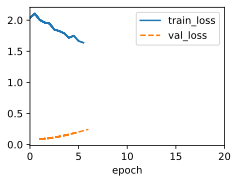

In [192]:
xavier_init_model = LinearRegression(lr=0.001, init_scheme='xavier')
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(xavier_init_model, data)

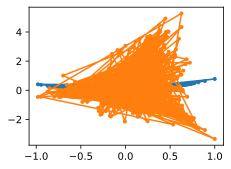

In [184]:
data.visualize(xavier_init_model)

In [123]:
xavier_init_model.net[2].weight, xavier_init_model.net[0].weight

(Parameter containing:
 tensor([[2.0153, 2.6298]], requires_grad=True),
 Parameter containing:
 tensor([[ 2.0081,  0.3453],
         [-0.3715,  2.3169]], requires_grad=True))

### Training with zero init model
- The weights never get any gradients, only the bias in last layer gets its gradient updated. That is the learning that is happening !

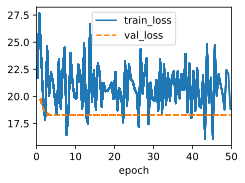

In [115]:
zero_init_model = LinearRegression(lr=0.01, init_scheme='zeros')
trainer = d2l.Trainer(max_epochs=50)
trainer.fit(zero_init_model, data)

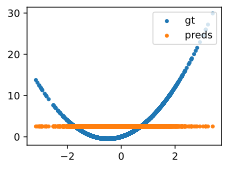

In [116]:
data.visualize(zero_init_model)

In [118]:
zero_init_model.net[2].weight, zero_init_model.net[0].weight, zero_init_model.net[2].bias, zero_init_model.net[0].bias

(Parameter containing:
 tensor([[0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([[0., 0.],
         [0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([2.5068], requires_grad=True),
 Parameter containing:
 tensor([0., 0.], requires_grad=True))

### Training with constant init model
- With a constant weight initialization, all neurons in a layer will get same gradients, no symmetry breaking

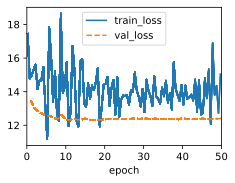

In [117]:
ones_init_model = LinearRegression(lr=0.01, init_scheme='ones')
trainer = d2l.Trainer(max_epochs=50)
trainer.fit(ones_init_model, data)

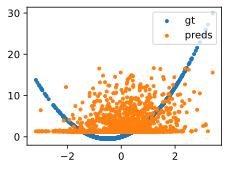

In [119]:
data.visualize(ones_init_model)

In [120]:
ones_init_model.net[2].weight, ones_init_model.net[0].weight

(Parameter containing:
 tensor([[1.6116, 1.6116]], requires_grad=True),
 Parameter containing:
 tensor([[0.5828, 1.8843],
         [0.5828, 1.8843]], requires_grad=True))